In [1]:
from torch.utils import tensorboard as tb
import torch
import torch.nn as nn
import torchvision
import pandas as pd
from packaging import version
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

/Users/ming/opt/anaconda3/envs/mps/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


find_file('./runs','Jan24_00-33-20_add80b3f7796seed_777_model_lenet_dataset_CIFAR10_bs_5_lr_0.1_size_100_alg_AMFED_sample_0.05_alpha_0.1_le_2_mu_0.1_imbalan_1_iid_2_sd_1_do_2_rep_4_inter_100_class_2_speedup_1.0')

----

New results from Jan 21 follows here

Settings: NON-IID (Dirichlet: 0.01), Imbalanced: Gaussian, Client Size: 100, Local Steps: 2* min(# of batches), Learning Rate: 0.2, Batch Size: 10;
        Drop-out 1: Uniformly At Random;
            Drop-out 2: Round Alternating: 4 Repetitions, 2 Communication Rounds;
                Drop-out 3: Drop-out forever after the first round;
                    Drop-out 4: Maximum Deviation Drop.


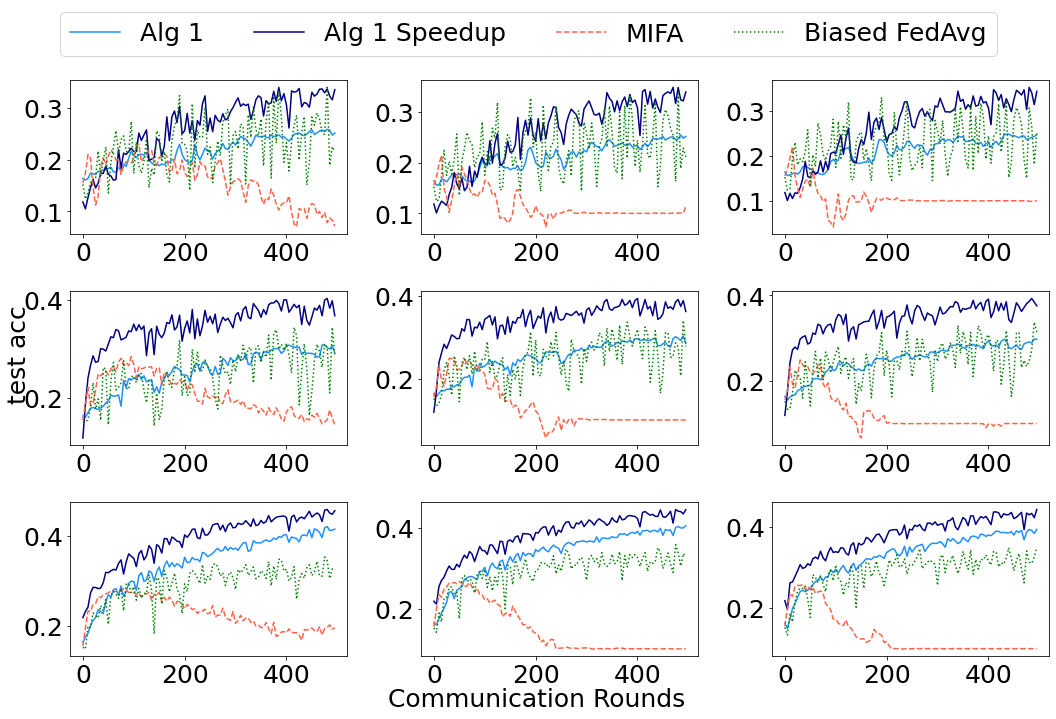

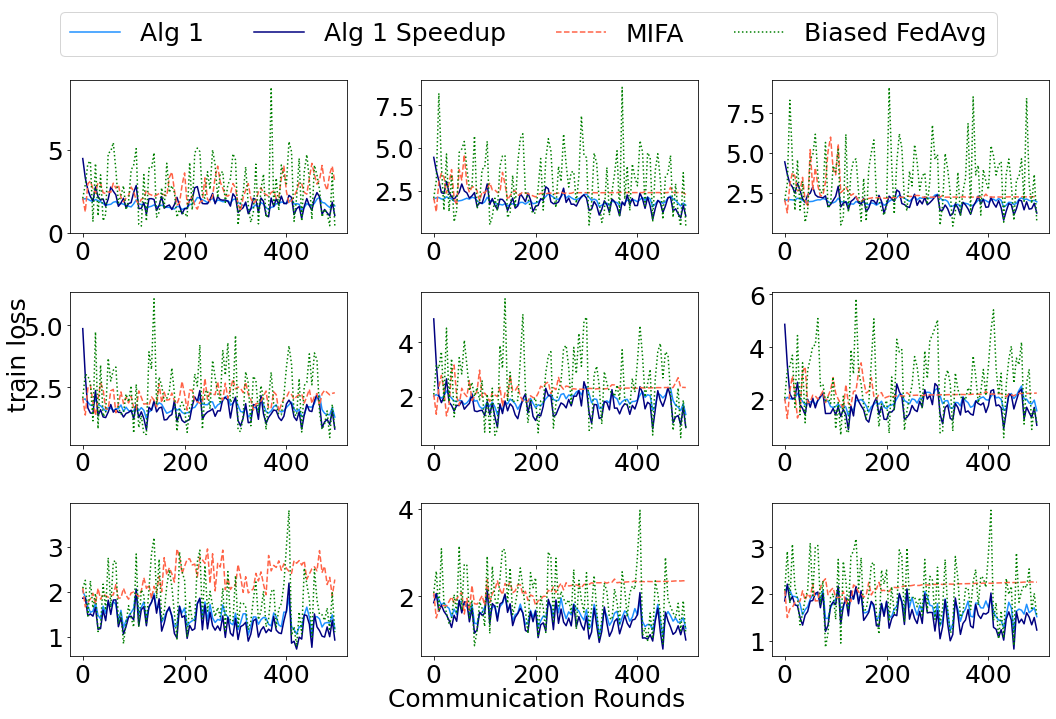

In [32]:
import os
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import matplotlib

SMALL_SIZE = 25
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)
# Extraction function
def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed


def find_file(directory, pattern):
    # iterate over files in that directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isdir(f) and f.endswith(pattern):
            break

    for filename in os.listdir(f):
        f = os.path.join(f, filename)
        # checking if it is a file
        if os.path.isfile(f):
            return f
        else:
            AssertionError

def pattern(alg,sample,alpha,sd,do,classes,repi,speedup):#bs,
   return 'size_100_alg_'+alg+'_sample_'+str(sample)+'_alpha_'+str(alpha)+'_le_2_mu_0.1_imbalan_1_iid_2_sd_'+str(sd)+'_do_'+str(do)+'_rep_'+str(repi)+'_inter_100_class_'+str(classes)+'_speedup_'+str(speedup)

# Jan24_00-33-20_add80b3f7796seed_777_model_lenet_dataset_CIFAR10_bs_5_lr_0.1_size_100_alg_AMFED_sample_0.05_alpha_0.1_le_2_mu_0.1_imbalan_1_iid_2_sd_1_do_2_rep_4_inter_100_class_2_speedup_1.0

def find_file(directory, pattern):
    # iterate over files in that directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isdir(f) and f.endswith(pattern):
            break

    for filename in os.listdir(f):
        f = os.path.join(f, filename)
        # checking if it is a file
        if os.path.isfile(f):
            return f
        else:
            AssertionError

def pattern(alg,sample,alpha,sd,do,classes,repi,speedup):#bs,
   return 'size_100_alg_'+alg+'_sample_'+str(sample)+'_alpha_'+str(alpha)+'_le_2_mu_0.1_imbalan_1_iid_2_sd_'+str(sd)+'_do_'+str(do)+'_rep_'+str(repi)+'_inter_100_class_'+str(classes)+'_speedup_'+str(speedup)

# Jan24_00-33-20_add80b3f7796seed_777_model_lenet_dataset_CIFAR10_bs_5_lr_0.1_size_100_alg_AMFED_sample_0.05_alpha_0.1_le_2_mu_0.1_imbalan_1_iid_2_sd_1_do_2_rep_4_inter_100_class_2_speedup_1.0

def find_and_plot(ax,directory,alg, sample,alpha,sd,do,metric,classes,repi,speedup,color,linestyle='solid'):
    pattern1 = pattern(alg,sr,alpha,sd,do,classes,repi,speedup)
    file_path = find_file(directory,pattern1)
    df = tflog2pandas(file_path)
    data_to_do = df[df.iloc[:,0]==metric].iloc[:,1][0:100]
    smoothed = data_to_do
    if alg == 'AMFED':
        alg = 'Alg 1'
    if alg == 'FEDAVG':
        alg = 'Biased FedAvg'
    if not speedup:
        ax.plot(np.arange(0,500,5),smoothed,label=alg,color=color,linestyle=linestyle)
    else:
        ax.plot(np.arange(0,500,5),smoothed,label=alg+' Speedup',color=color,linestyle=linestyle)

"""do: dropout scheme number 1 for dropout scheme 1, 2 for dropout scheme 2"""
"""sr_list: sample frac list"""
"""alpha_list: adversarial dropout alpha fraction"""
"""sd: step decay indicator"""
"""directory that records the results."""

directory = './runscifar'
do=3
sd = 1
sr_list = [0.05,0.1,0.3]
rep = [4,5,10]
alpha_list = [0.1,0.2,0.25]
metric = 'test acc'

fig,axs = plt.subplots(3,3,figsize=(15,10))
for r_ind, row in enumerate(axs):
    for c_ind, col in enumerate(row):
        sr = sr_list[r_ind]
        if do==2:
            repi = rep[c_ind]
            alpha = 0.1
        elif do==3:
            repi=4
            alpha = alpha_list[c_ind]
        find_and_plot(col,directory,'AMFED',sr,alpha,sd,do,metric,2,repi,0,'dodgerblue')
        find_and_plot(col,directory,'AMFED',sr,alpha,sd,do,metric,2,repi,1.0,'navy')
        find_and_plot(col,directory,'MIFA',sr,alpha,sd,do,metric,2,repi,0,'tomato',linestyle='dashed')
        find_and_plot(col,directory,'FEDAVG',sr,alpha,sd,do,metric,2,repi,0,'green',linestyle='dotted')

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4)
fig.text(0.5, 0.01, 'Communication Rounds', ha='center')
fig.text(0.01, 0.5, metric, va='center', rotation='vertical')
fig.tight_layout()
plt.subplots_adjust(top=0.88)
if sd == 1:
    plt.savefig('CIFAR_dropout'+str(do)+'_decay_acc.pdf',dpi=600,bbox_inches='tight')
else:
    plt.savefig('CIFAR_dropout'+str(do)+'_no_decay_acc.pdf',dpi=600, bbox_inches='tight')


metric = 'train loss'

fig,axs = plt.subplots(3,3,figsize=(15,10))
for r_ind, row in enumerate(axs):
    for c_ind, col in enumerate(row):
        sr = sr_list[r_ind]
        if do==2:
            repi = rep[c_ind]
            alpha = 0.1
        elif do==3:
            repi=4
            alpha = alpha_list[c_ind]
        find_and_plot(col,directory,'AMFED',sr,alpha,sd,do,metric,2,repi,0,'dodgerblue')
        find_and_plot(col,directory,'AMFED',sr,alpha,sd,do,metric,2,repi,1.0,'navy')
        find_and_plot(col,directory,'MIFA',sr,alpha,sd,do,metric,2,repi,0,'tomato',linestyle='dashed')
        find_and_plot(col,directory,'FEDAVG',sr,alpha,sd,do,metric,2,repi,0,'green',linestyle='dotted')

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4)
fig.text(0.5, 0.01, 'Communication Rounds', ha='center')
fig.text(0.01, 0.5, metric, va='center', rotation='vertical')
fig.tight_layout()
plt.subplots_adjust(top=0.88)
if sd == 1:
    plt.savefig('CIFAR_dropout'+str(do)+'_decay_loss.pdf',dpi=600, bbox_inches='tight')
else:
    plt.savefig('CIFAR_dropout'+str(do)+'_no_decay_loss.pdf',dpi=600, bbox_inches='tight')



Settings: NON-IID (Dirichlet: 0.01), Imbalanced: Gaussian, Client Size: 100, Local Steps: 2* min(# of batches), Learning Rate: 0.2, Batch Size: 10;
        Drop-out 1: Uniformly At Random;
            Drop-out 2: Round Alternating: 4 Repetitions, 2 Communication Rounds;
                Drop-out 3: Drop-out forever after the first round;
                    Drop-out 4: Maximum Deviation Drop.


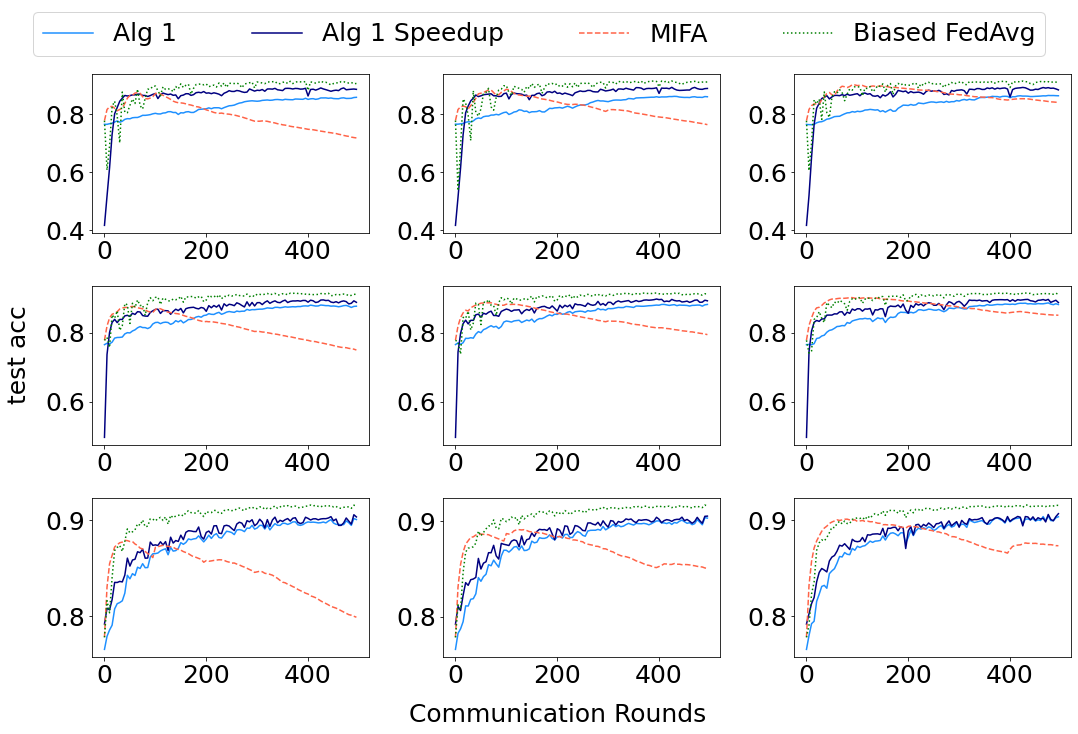

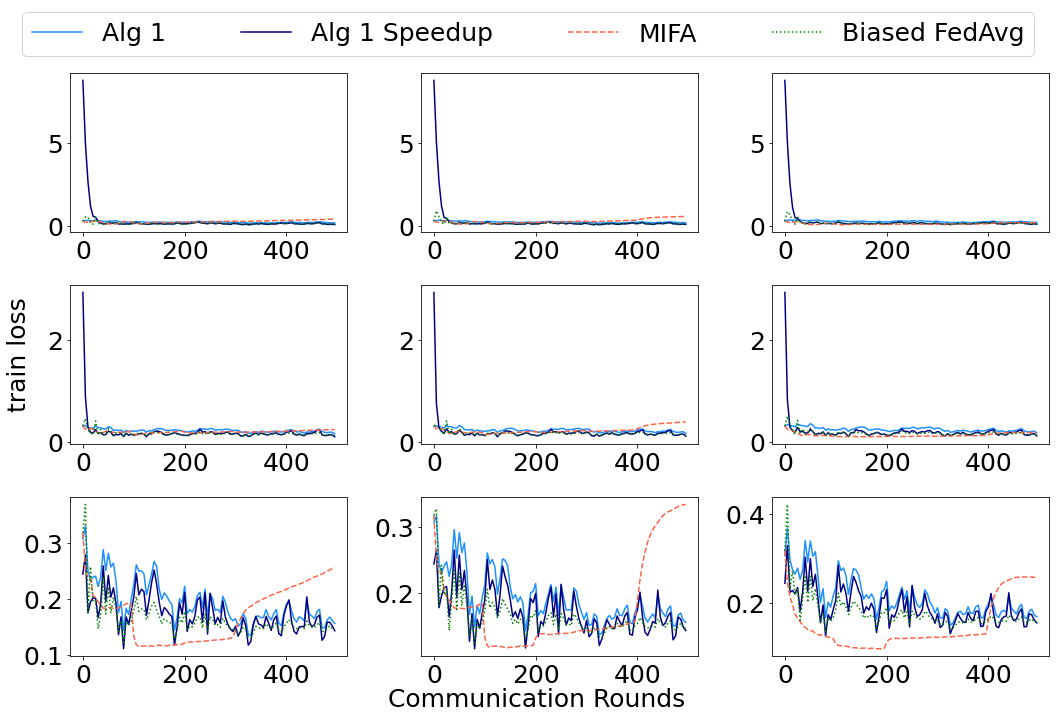

In [25]:
import os
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
# Extraction function

import os
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

SMALL_SIZE = 25
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)
# Extraction function
def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

def find_file(directory, pattern):
    # iterate over files in that directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isdir(f) and f.endswith(pattern):
            break

    for filename in os.listdir(f):
        f = os.path.join(f, filename)
        # checking if it is a file
        if os.path.isfile(f):
            return f
        else:
            AssertionError

def pattern(alg,sample,alpha,sd,do,classes,repi,speedup):#bs,
   return 'size_100_alg_'+alg+'_sample_'+str(sample)+'_alpha_'+str(alpha)+'_le_2_mu_0.1_imbalan_1_iid_2_sd_'+str(sd)+'_do_'+str(do)+'_rep_'+str(repi)+'_inter_100_class_'+str(classes)+'_speedup_'+str(speedup)

# Jan24_00-33-20_add80b3f7796seed_777_model_lenet_dataset_CIFAR10_bs_5_lr_0.1_size_100_alg_AMFED_sample_0.05_alpha_0.1_le_2_mu_0.1_imbalan_1_iid_2_sd_1_do_2_rep_4_inter_100_class_2_speedup_1.0

def find_and_plot(ax,directory,alg, sample,alpha,sd,do,metric,classes,repi,speedup,color,linestyle='solid'):
    pattern1 = pattern(alg,sr,alpha,sd,do,classes,repi,speedup)
    file_path = find_file(directory,pattern1)
    df = tflog2pandas(file_path)
    data_to_do = df[df.iloc[:,0]==metric].iloc[:,1][0:100]
    smoothed = data_to_do
    # smoothed = smooth(data_to_do,0.1)
    if alg == 'AMFED':
        alg = 'Alg 1'
    if alg == 'FEDAVG':
        alg = 'Biased FedAvg'
    if not speedup:
        ax.plot(np.arange(0,500,5),smoothed,label=alg,color=color,linestyle=linestyle)
    else:
        ax.plot(np.arange(0,500,5),smoothed,label=alg+' Speedup',color=color,linestyle=linestyle)

"""do: dropout scheme number 1 for dropout scheme 1, 2 for dropout scheme 2"""
"""sr_list: sample frac list"""
"""alpha_list: adversarial dropout alpha fraction"""
"""sd: step decay indicator"""
"""directory that records the results."""

directory = './runsmnist'
do = 2
sr_list = [0.05,0.1,0.3]
rep = [4,5,10]
alpha_list=[0.1, 0.2, 0.25]
sd=1

metric = 'test acc'

fig,axs = plt.subplots(3,3,figsize=(15,10))
for r_ind, row in enumerate(axs):
    for c_ind, col in enumerate(row):
        sr = sr_list[r_ind]
        if do==2:
            repi = rep[c_ind]
            alpha = 0.1
        elif do==3:
            repi=4
            alpha = alpha_list[c_ind]
        find_and_plot(col,directory,'AMFED',sr,alpha,sd,do,metric,2,repi,0,'dodgerblue')
        find_and_plot(col,directory,'AMFED',sr,alpha,sd,do,metric,2,repi,1.0,'navy')
        find_and_plot(col,directory,'MIFA',sr,alpha,sd,do,metric,2,repi,0,'tomato',linestyle='dashed')
        find_and_plot(col,directory,'FEDAVG',sr,alpha,sd,do,metric,2,repi,0,'green',linestyle='dotted')

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4,columnspacing=3)
fig.text(0.5, -0.01, 'Communication Rounds', ha='center')
fig.text(-0.01, 0.5, metric, va='center', rotation='vertical')
fig.tight_layout()
plt.subplots_adjust(top=0.89)
plt.savefig('MNIST_dropout'+str(do)+'_decay_acc.pdf',dpi=600, bbox_inches='tight')

metric = 'train loss'

fig,axs = plt.subplots(3,3,figsize=(15,10))
for r_ind, row in enumerate(axs):
    for c_ind, col in enumerate(row):
        sr = sr_list[r_ind]
        if do==2:
            repi = rep[c_ind]
            alpha = 0.1
        elif do==3:
            repi=4
            alpha = alpha_list[c_ind]
        find_and_plot(col,directory,'AMFED',sr,alpha,sd,do,metric,2,repi,0,'dodgerblue')
        find_and_plot(col,directory,'AMFED',sr,alpha,sd,do,metric,2,repi,1.0,'navy')
        find_and_plot(col,directory,'MIFA',sr,alpha,sd,do,metric,2,repi,0,'tomato',linestyle='dashed')
        find_and_plot(col,directory,'FEDAVG',sr,alpha,sd,do,metric,2,repi,0,'green',linestyle='dotted')

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4,columnspacing=3)
fig.text(0.5, 0.01, 'Communication Rounds', ha='center')
fig.text(0.01, 0.5, metric, va='center', rotation='vertical')
fig.tight_layout()
plt.subplots_adjust(top=0.89)
plt.savefig('MNIST_dropout'+str(do)+'_decay_loss.pdf',dpi=600)

